#Calteh Birds Classification
This Project is done using Google Colaboratory. 1st you have to mount google drive with Colab and place dataset in zipped format on Google drive to access it. This dataset contains birds images of 200 categories. Training images are 5994 & test images are 5794. I have achieved top1 accuracy 77.32% and top5 accuracy 94.30% on test set. This project is done using a ResNet18(pretrained on imagenet).

In [1]:
!unzip drive/My\ Drive/TFM/Birds-Task-PyTorch/CUB_200_PyTorch.zip # this line copies the birds dataset from Google drive to Google Colab and also Unzip it for further processing.

Streaming output truncated to the last 5000 lines.
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0047_30393.jpg  
 extracting: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0052_30321.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0058_30143.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0061_30429.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0063_30190.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0070_30147.jpg  
 extracting: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0075_30441.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0077_30296.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0081_30380.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flycatcher/Least_Flycatcher_0082_30132.jpg  
  inflating: CUB_200_PyTorch/train/039.Least_Flyc

In [2]:
# here are the necessary imports
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
plt.ion()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load Data
We will use torchvision and torch.utils.data packages for loading the data. For the training, i have applied transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. I also made it sure that the input data is resized to 224x224 pixels as required by the pre-trained networks.

The testing set is used to measure the model's performance on data it hasn't seen yet. For this i have not performed any scaling or rotation transformations, but i had resized and then cropped the images to the appropriate size.

The pre-trained network i have used was trained on the ImageNet dataset where each color channel was normalized separately. For all three sets i have normalized the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CUB_200_PyTorch'
# loading datasets with PyTorch ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [4]:
dataset_sizes

{'test': 5794, 'train': 5994}

#Visualize a few images
Let's visualize a few training images so as to understand the data augmentations.

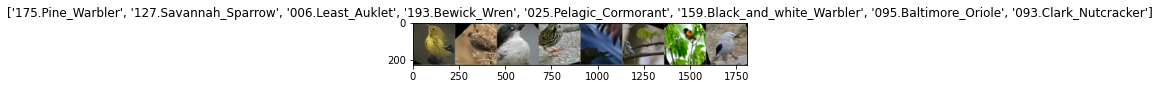

In [5]:
def imshow_tensors(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow_tensors(out, title=[class_names[x] for x in classes])

#Training the model
Now, let's write a general function to train a model. I also have written code to save the best checkpoint within Google drive for using next time

In [0]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
                losses_list, accuracies_list = train_losses, train_accuracies
            else:
                model.train(False)  # Set model to evaluate mode
                losses_list, accuracies_list = test_losses, test_accuracies

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() #loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            losses_list.append(epoch_loss)
            accuracies_list.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                # torch.save(state,'./drive/My Drive/TFM/Birds-Task-PyTorch/point_resnet18_best.pth')
                torch.save(state,'./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Return best model and statistics
    train_losses, train_accuracies = np.array(train_losses), np.array(train_accuracies)
    test_losses, test_accuracies = np.array(test_losses), np.array(test_accuracies)
    stats = {'train_loss':train_losses, 'train_acc':train_accuracies, 'test_loss':test_losses, 'test_acc':test_accuracies}
    return model, stats

#Visualizing the model predictions
Generic function to display predictions for a few images

In [0]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['test']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        # print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        # print(outputs)
        _, preds = torch.max(outputs.data, 1)
        # print(preds)

        # probs = torch.softmax(outputs, dim=1)
        # print(probs)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow_tensors(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

#Finetuning the convnet
Load a pretrained Resnet 18 model and reset final fully connected layer.

In [0]:
# model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
model_ft = models.resnet50(pretrained=False)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      # changing the last layer for this dataset by setting last layer neurons to 200 as this dataset has 200 categories

if use_gpu:                                 # if gpu is available then use it
    model_ft = model_ft.cuda()       
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()           # defining loss function

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

You can load a checkpoint from your my drive or any other place if you have saved it. you have to load weights of model and optimizer

In [9]:
checkpoint = torch.load('./drive/My Drive/TFM/Birds-Task-PyTorch/main_resnet50_best.pth')
model_ft.load_state_dict(checkpoint['model'])
# optimizer_ft.load_state_dict(checkpoint['optim'])
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#Train and evaluate

In [0]:
model_ft, stats = train_model(model_ft, criterion, optimizer_ft,num_epochs=200)

Epoch 0/199
----------
train Loss: 0.6618 Acc: 0.0108
test Loss: 0.6450 Acc: 0.0324

Epoch 1/199
----------
train Loss: 0.6420 Acc: 0.0414
test Loss: 0.6130 Acc: 0.1115

Epoch 2/199
----------
train Loss: 0.6171 Acc: 0.0863
test Loss: 0.5639 Acc: 0.1904

Epoch 3/199
----------
train Loss: 0.5857 Acc: 0.1403
test Loss: 0.5089 Acc: 0.2654

Epoch 4/199
----------
train Loss: 0.5537 Acc: 0.1723
test Loss: 0.4609 Acc: 0.3165

Epoch 5/199
----------
train Loss: 0.5240 Acc: 0.2110
test Loss: 0.4249 Acc: 0.3592

Epoch 6/199
----------
train Loss: 0.4984 Acc: 0.2452
test Loss: 0.3913 Acc: 0.4006

Epoch 7/199
----------
train Loss: 0.4747 Acc: 0.2784
test Loss: 0.3582 Acc: 0.4329

Epoch 8/199
----------
train Loss: 0.4503 Acc: 0.3070
test Loss: 0.3325 Acc: 0.4691

Epoch 9/199
----------
train Loss: 0.4321 Acc: 0.3330
test Loss: 0.3057 Acc: 0.4903

Epoch 10/199
----------
train Loss: 0.4136 Acc: 0.3527
test Loss: 0.2824 Acc: 0.5197

Epoch 11/199
----------
train Loss: 0.3953 Acc: 0.3812
test Loss

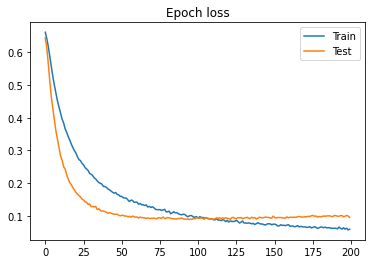

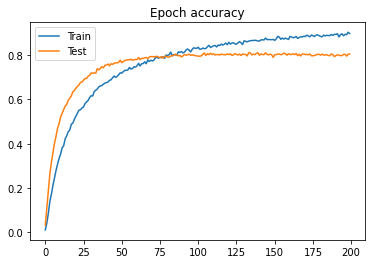

In [0]:
# SHOW LOSS AND ACCURACIES CURVES
plt.plot(stats['train_loss'], label='Train')
plt.plot(stats['test_loss'], label='Test')
plt.title('Epoch loss')
plt.legend()
plt.show()

plt.plot(stats['train_acc'], label='Train')
plt.plot(stats['test_acc'], label='Test')
plt.title('Epoch accuracy')
plt.legend()
plt.show()

#Checking Model's Predictions

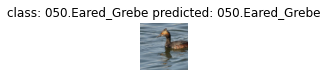

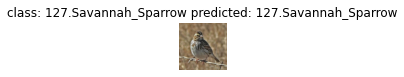

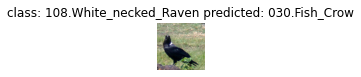

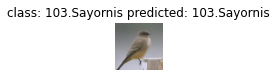

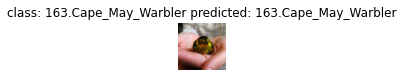

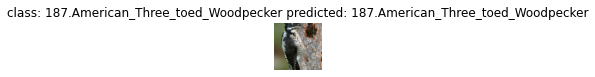

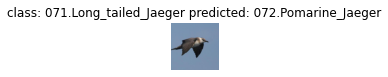

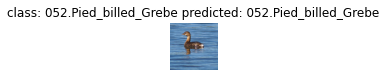

In [13]:
visualize_model(model_ft)

# Finding Top-1 & Top-5 accuracy

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def calc_accuracy(model, data):
    model.eval()
    if use_gpu:
      model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloders[data]):
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        prec1, prec5 = accuracy(outputs, Variable(labels), topk=(1, 5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

top1, top5 = calc_accuracy(model_ft, 'test')

In [11]:
top1.avg, top5.avg

(tensor(81.0321, device='cuda:0'), tensor(95.3227, device='cuda:0'))

## Top-1 & Top-5 for train

In [15]:
top1, top5 = calc_accuracy(model_ft, 'train')
top1.avg, top5.avg

(tensor(89.7564, device='cuda:0'), tensor(95.4288, device='cuda:0'))

# Inference for classification

In [0]:
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    # PyTorch tensors assume the color channel is first
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    return ax

In [19]:
os.listdir('CUB_200_PyTorch/test/001.Black_footed_Albatross/')

['Black_Footed_Albatross_0042_796071.jpg',
 'Black_Footed_Albatross_0041_796108.jpg',
 'Black_Footed_Albatross_0038_212.jpg',
 'Black_Footed_Albatross_0023_796059.jpg',
 'Black_Footed_Albatross_0032_796115.jpg',
 'Black_Footed_Albatross_0003_796136.jpg',
 'Black_Footed_Albatross_0074_59.jpg',
 'Black_Footed_Albatross_0067_170.jpg',
 'Black_Footed_Albatross_0001_796111.jpg',
 'Black_Footed_Albatross_0025_796057.jpg',
 'Black_Footed_Albatross_0036_796127.jpg',
 'Black_Footed_Albatross_0071_796113.jpg',
 'Black_Footed_Albatross_0051_796103.jpg',
 'Black_Footed_Albatross_0079_796122.jpg',
 'Black_Footed_Albatross_0007_796138.jpg',
 'Black_Footed_Albatross_0060_796076.jpg',
 'Black_Footed_Albatross_0086_796062.jpg',
 'Black_Footed_Albatross_0045_796129.jpg',
 'Black_Footed_Albatross_0068_796135.jpg',
 'Black_Footed_Albatross_0077_796114.jpg',
 'Black_Footed_Albatross_0026_796095.jpg',
 'Black_Footed_Albatross_0058_796074.jpg',
 'Black_Footed_Albatross_0040_796066.jpg',
 'Black_Footed_Albatr

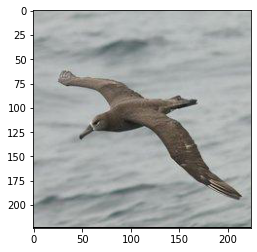

In [20]:
image_path = 'CUB_200_PyTorch/test/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg'
img = process_image(image_path)
imshow(img)

# Predict Top-k

In [0]:
def predict(image_path, model, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    output = model.forward(Variable(model_input.cuda()))
    # print(output.shape)
    probs = torch.softmax(output, dim=1)

    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs, top_labs = top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    
    top_birds = [class_names[lab] for lab in top_labs]
    return top_probs, top_birds

def plot_main_prediction(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    title_ = image_path.split('/')[2]
    
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, birds = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=birds, color=sns.color_palette()[0]);
    plt.show()

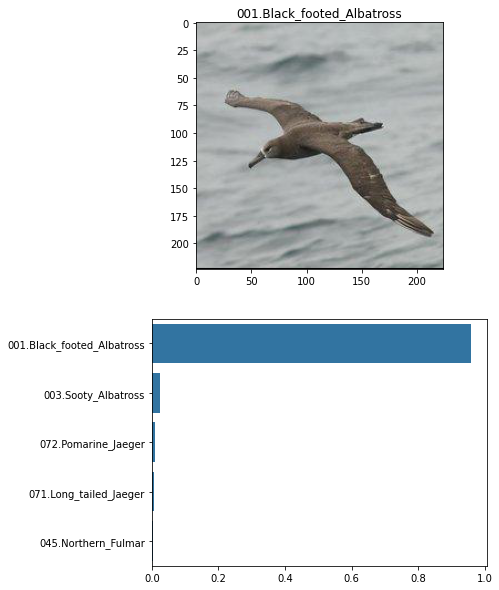

In [22]:
plot_main_prediction(image_path, model_ft)